In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

np.random.seed(10)

gender_pallete = sns.color_palette(['#F25278', '#1261A0'])
survived_pallete = sns.color_palette(['#D78674', '#827EA4'])

In [2]:
train_file = 'https://raw.githubusercontent.com/WindyCatHub/Journey-to-Data-Science/main/Jupyter_Notebook__Titanic/train.csv'
test_file = 'https://raw.githubusercontent.com/WindyCatHub/Journey-to-Data-Science/main/Jupyter_Notebook__Titanic/test.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)


In [3]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
test_data.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [5]:
X_full = train_data.append(test_data, sort=False)


<AxesSubplot:>

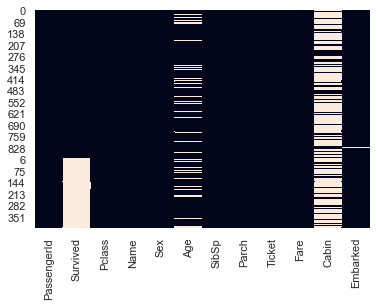

In [6]:
sns.heatmap(X_full.isnull(), cbar=False)

In [7]:
X_features = ['PassengerId','Pclass', 'Name', 'Sex' , 'Age', 'SibSp', 'Parch', 'Fare' ,'Cabin','Embarked', 'Ticket']
y_features = 'Survived'

X = X_full

In [8]:
print('Total # of rows ', len(X))
print('Missing Values:')
print(X.isnull().sum())
print('\n')

Total # of rows  1309
Missing Values:
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64




# Filling missing values of age

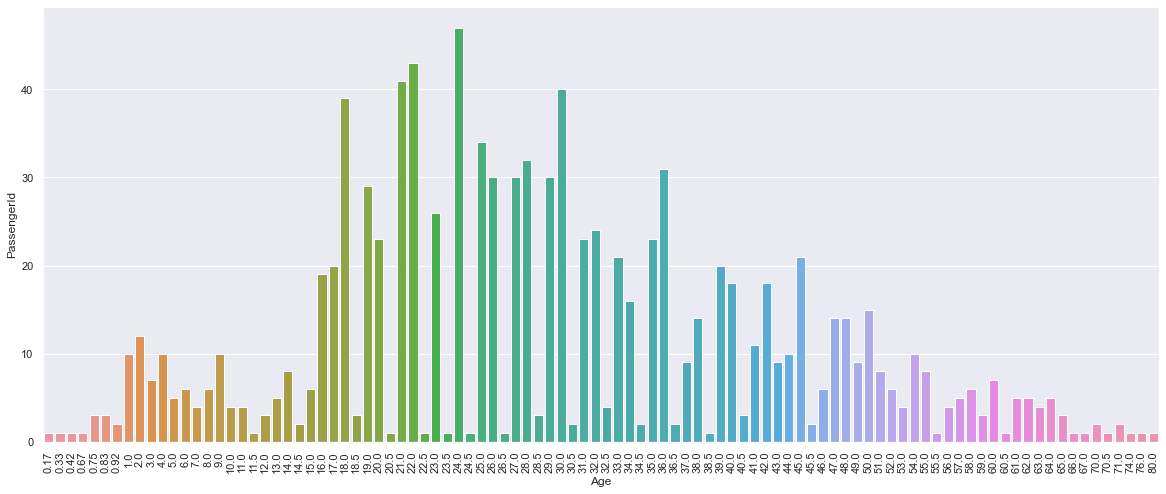

In [9]:
fig, ax = plt.subplots(figsize=(20,8))
Age_frec = X[['Age', 'PassengerId']].groupby('Age').count().reset_index()
g = sns.barplot(x="Age", y = 'PassengerId',
                data=Age_frec, ax=ax)

g = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

There are some records with half of the age like 26.5. I will round to age to integer. 

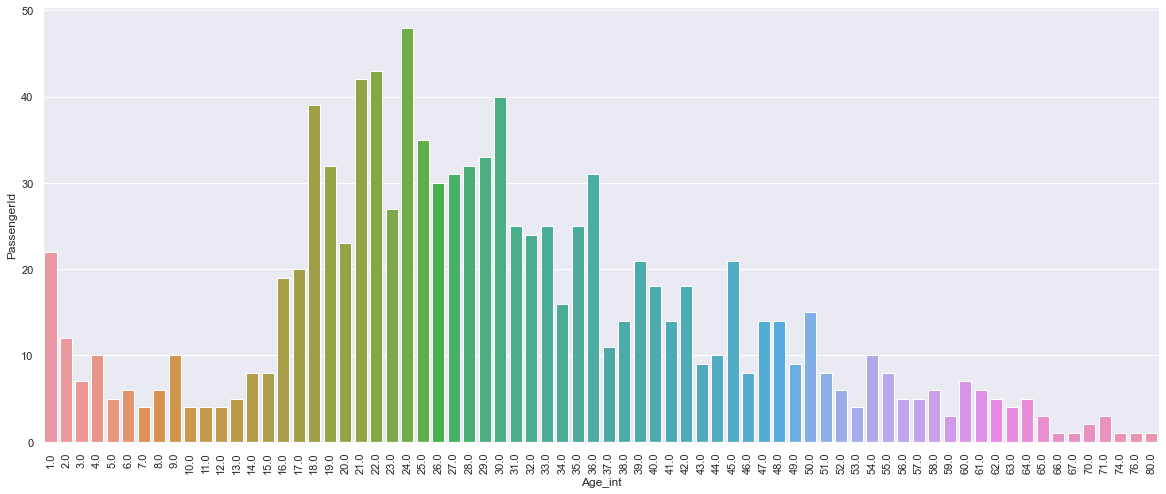

In [10]:
X['Age_intervals'] = pd.cut(X.Age, bins=np.linspace(0, 80, 81))
X['Age_int'] = X.Age_intervals.cat.codes+1
X['Age_int'] = X['Age_int'].replace(0, np.nan)
X = X.drop('Age_intervals', axis = 1)
fig, ax = plt.subplots(figsize=(20,8))
Age_frec = X[['Age_int', 'PassengerId']].groupby('Age_int').count().reset_index()
g = sns.barplot(x="Age_int", y = 'PassengerId',
                data=Age_frec, ax=ax)

g = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

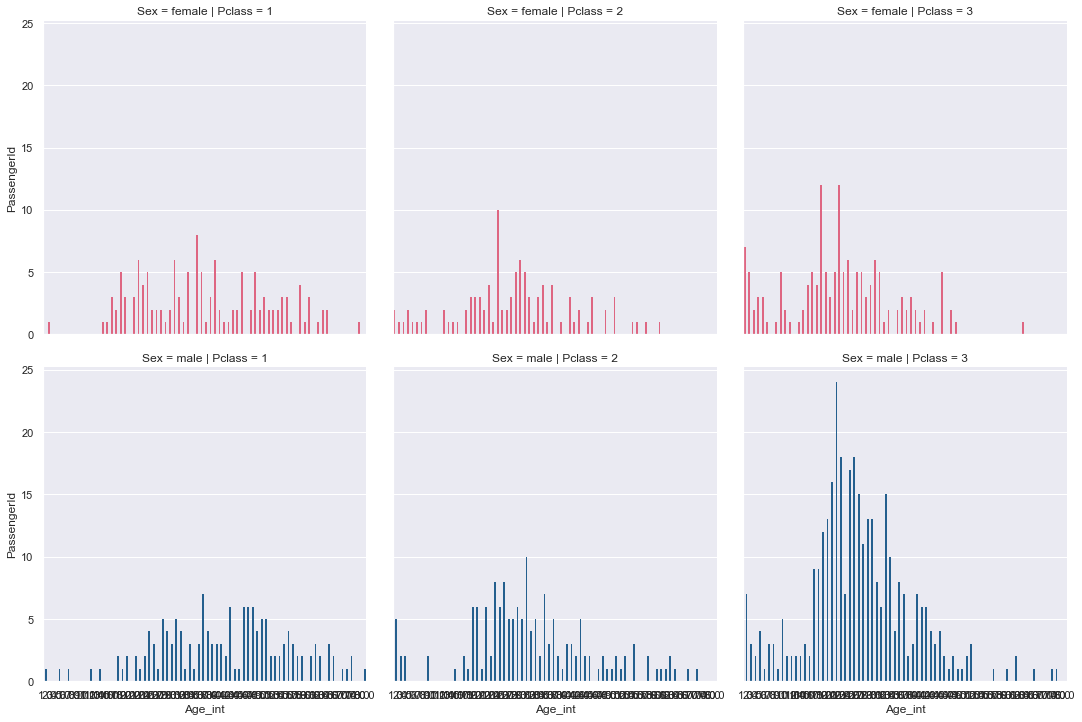

In [11]:
Age_frec = X[['Pclass','Sex','Age_int', 'PassengerId']].groupby(['Pclass','Sex','Age_int']).count().reset_index()

g = sns.catplot(x="Age_int", y = 'PassengerId',row = 'Sex', col = 'Pclass', hue = 'Sex',
                data=Age_frec, kind = 'bar', palette=gender_pallete, linewidth=0)


Age filling with mod in Sex and Pclass groups

In [12]:
X_features_selection = ['Pclass', 'Sex',"Age_int"]
Fix_all = X[X_features_selection].groupby(['Pclass', 'Sex']).agg(mod  = ('Age_int', lambda x: x.value_counts().index[0]))

Mod = Fix_all['mod'].reset_index() 

X = pd.merge(X, Mod, on =['Pclass', 'Sex'],  how ='left') 
X['Age_mod'] = X['Age_int']
X['Age_mod'] = X['Age_mod'].fillna(X['mod'])

X = X.drop('mod', axis = 1)

sns.heatmap(X.sort_values(by = 'Pclass').isnull(), cbar=False)

<AxesSubplot:>

Age filling with distribution

In [13]:
def frec_table(dataset, col1, col2, col_count):
    s = dataset[[col1, col2, col_count]].groupby([col1, col2]).count().reset_index()
    l = dataset[[col1, col_count]].groupby([col1]).count().reset_index()
    Full = pd.merge(s,l, on  = col1, how = 'left')
    Full['frec'] = Full.PassengerId_x/Full.PassengerId_y
    return Full

<AxesSubplot:>

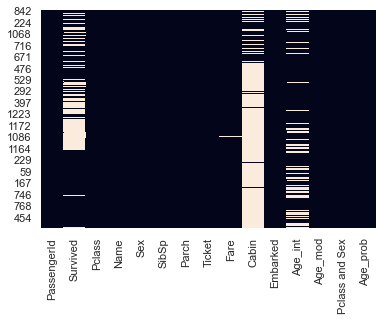

In [14]:
X['Pclass and Sex']=X['Pclass'].astype('str').str.cat(X['Sex'].astype('str'), sep =" ")
X1 = X.dropna()
A  =frec_table(X1, 'Pclass and Sex', 'Age_int', 'PassengerId')

c = X.Age_int.isnull()
c1 = X['Pclass and Sex']=='1 male'
c2 = X['Pclass and Sex']=='2 male'
c3 = X['Pclass and Sex']=='3 male'

c4 = X['Pclass and Sex']=='1 female'
c5 = X['Pclass and Sex']=='2 female'
c6 = X['Pclass and Sex']=='3 female'


X['Age_prob'] = X.Age_int


P1 = np.random.choice(A[A['Pclass and Sex']=='1 male'].Age_int, p=A[A['Pclass and Sex']=='1 male'].frec, size=X[X['Pclass and Sex']=='1 male'].Age_int.isna().sum())

P2 = np.random.choice(A[A['Pclass and Sex']=='2 male'].Age_int, p=A[A['Pclass and Sex']=='2 male'].frec, size=X[X['Pclass and Sex']=='2 male'].Age_int.isna().sum())

P3 = np.random.choice(A[A['Pclass and Sex']=='3 male'].Age_int, p=A[A['Pclass and Sex']=='3 male'].frec, size=X[X['Pclass and Sex']=='3 male'].Age_int.isna().sum())

P4 = np.random.choice(A[A['Pclass and Sex']=='1 female'].Age_int, p=A[A['Pclass and Sex']=='1 female'].frec, size=X[X['Pclass and Sex']=='1 female'].Age_int.isna().sum())

P5 = np.random.choice(A[A['Pclass and Sex']=='2 female'].Age_int, p=A[A['Pclass and Sex']=='2 female'].frec, size=X[X['Pclass and Sex']=='2 female'].Age_int.isna().sum())

P6 = np.random.choice(A[A['Pclass and Sex']=='3 female'].Age_int, p=A[A['Pclass and Sex']=='3 female'].frec, size=X[X['Pclass and Sex']=='3 female'].Age_int.isna().sum())

X.loc[(X.Age_int.isnull()) & (c1), 'Age_prob'] = P1
X.loc[(X.Age_int.isnull()) & (c2), 'Age_prob'] = P2
X.loc[(X.Age_int.isnull()) & (c3), 'Age_prob'] = P3

X.loc[(X.Age_int.isnull()) & (c4), 'Age_prob'] = P4
X.loc[(X.Age_int.isnull()) & (c5), 'Age_prob'] = P5
X.loc[(X.Age_int.isnull()) & (c6), 'Age_prob'] = P6

X=X.drop(["Age"], axis=1)

sns.heatmap(X.sort_values(by = 'Pclass').isnull(), cbar=False)

In [15]:
fig, ax = plt.subplots(1,3,figsize=(20,8))
Age_frec = X[['Age_int', 'PassengerId']].groupby('Age_int').count().reset_index()
g = sns.barplot(x="Age_int", y = 'PassengerId',
                data=Age_frec, ax=ax[0])
ax[0].set_title("Age without imputation")

Age_frec_mod = X[['Age_mod', 'PassengerId']].groupby('Age_mod').count().reset_index()
g = sns.barplot(x="Age_mod", y = 'PassengerId',
                data=Age_frec_mod, ax=ax[1], ci = None)
ax[1].set_title("Age with mod in groups imputation")

Age_frec_prob = X[['Age_prob', 'PassengerId']].groupby('Age_prob').count().reset_index()
g = sns.barplot(x="Age_prob", y = 'PassengerId',
                data=Age_frec_prob, ax=ax[2], ci = None)
ax[2].set_title("Age with density imputation")

Text(0.5, 1.0, 'Age with density imputation')

# Filling missing values of Embarked and Fare

In [16]:
display(X[X.Embarked.isnull()])

sns.catplot(x="Embarked", kind="count", palette="ch:.25", data=X,   col = 'Pclass')

PassengerId  Survived  Pclass                                       Name  \
61            62       1.0       1                        Icard, Miss. Amelie   
829          830       1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)   

        Sex  SibSp  Parch  Ticket  Fare Cabin Embarked  Age_int  Age_mod  \
61   female      0      0  113572  80.0   B28      NaN     38.0     38.0   
829  female      0      0  113572  80.0   B28      NaN     62.0     62.0   

    Pclass and Sex  Age_prob  
61        1 female      38.0  
829       1 female      62.0

In [17]:
X.loc[X['PassengerId'] == 62, 'Embarked'] = "S"
X.loc[X['PassengerId'] == 830, 'Embarked'] = "S"

In [18]:
X[X.Fare.isnull()]

PassengerId  Survived  Pclass                Name   Sex  SibSp  Parch  \
1043         1044       NaN       3  Storey, Mr. Thomas  male      0      0   

     Ticket  Fare Cabin Embarked  Age_int  Age_mod Pclass and Sex  Age_prob  
1043   3701   NaN   NaN        S     61.0     61.0         3 male      61.0

In [19]:
X[X.Ticket == '3701']

PassengerId  Survived  Pclass                Name   Sex  SibSp  Parch  \
1043         1044       NaN       3  Storey, Mr. Thomas  male      0      0   

     Ticket  Fare Cabin Embarked  Age_int  Age_mod Pclass and Sex  Age_prob  
1043   3701   NaN   NaN        S     61.0     61.0         3 male      61.0

In [20]:
temp = X[X.Pclass==3]
temp = temp.drop([1043])
temp = temp[['PassengerId', 'Ticket', 'Fare']].groupby('Ticket').agg({'PassengerId': 'count', 'Fare': 'mean'})
temp['price'] = temp.Fare/temp.PassengerId
display(temp.describe())
temp.price.value_counts().head()

PassengerId        Fare       price
count   548.000000  548.000000  548.000000
mean      1.291971    9.469042    7.701180
std       0.974337    5.483465    1.214594
min       1.000000    0.000000    0.000000
25%       1.000000    7.740650    7.250000
50%       1.000000    7.895800    7.775000
75%       1.000000    8.411475    8.050000
max      11.000000   69.550000   19.966700

8.0500    66
7.7500    61
7.8958    49
7.7750    27
7.9250    25
Name: price, dtype: int64

In [21]:
X.loc[X.Ticket == '3701', 'Fare'] = 8.0500

## Filling missing values in Cabin

In [22]:
X.Cabin.dropna().values

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73',
       'C23 C25 C27', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60',
       'E101', 'D26', 'F E69', 'D47', 'C123', 'B86', 'F2', 'C2', 'E33',
       'B19', 'A7', 'C49', 'F4', 'A32', 'F2', 'B4', 'B80', 'G6', 'A31',
       'D36', 'D15', 'C93', 'C83', 'C78', 'D35', 'G6', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'B58 B60', 'E101', 'C22 C26', 'C65', 'E36',
       'C54', 'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'D', 'B18', 'C124',
       'C91', 'C2', 'E40', 'T', 'F2', 'C23 C25 C27', 'F33', 'C128', 'E33',
       'D37', 'B35', 'E50', 'C82', 'B96 B98', 'D36', 'G6', 'C78', 'E10',
       'C52', 'E44', 'B96 B98', 'C23 C25 C27', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'D', 'A14', 'B49', 'C93', 'B37',
       'C30', 'D20', 'C22 C26', 'B79', 'C65', 'E25', 'D46', 'F33', 'B73',


In [23]:
no_digits = []
for cabin in X.Cabin[~X.Cabin.isnull()]:
    letter = ''    
    for l in cabin:
        if l.isalpha():
            letter = letter + l
    no_digits.append("".join(set(letter)))


A = X.Cabin.dropna().reset_index()
Cabin = pd.concat([A, pd.DataFrame(no_digits)], axis = 1)
T = X.reset_index()

X = pd.merge(T, Cabin, on="index", how = "left").drop(['index', 'Cabin_x', 'Cabin_y'], axis=1)\
                                                .rename(columns={0:'Cabin'})
X.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    male      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female      1      0   
2                             Heikkinen, Miss. Laina  female      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female      1      0   
4                           Allen, Mr. William Henry    male      0      0   

             Ticket     Fare Embarked  Age_int  Age_mod Pclass and Sex  \
0         A/5 21171   7.2500        S     22.0     22.0         3 male   
1          PC 17599  71.2833        C     38.0     38.0       1 female   
2  STON/O2. 3101282   7.9250        S     26.0     26.0       3 female   
3            113803  53.1000        S     35.0     35.0       1 female   
4            373450   8.0500        S     35.0     35.0         3 male   

   Age_prob Cabin  
0      22.0   NaN  
1      38.0     C  
2      26.0   NaN  
3      35.0     C  
4      35.0   NaN

In [24]:
order = list(X.Cabin.dropna().unique())
sns.catplot(x="Cabin", kind="count", palette="ch:.25", data=X, col = 'Pclass', 
            order = sorted(order))

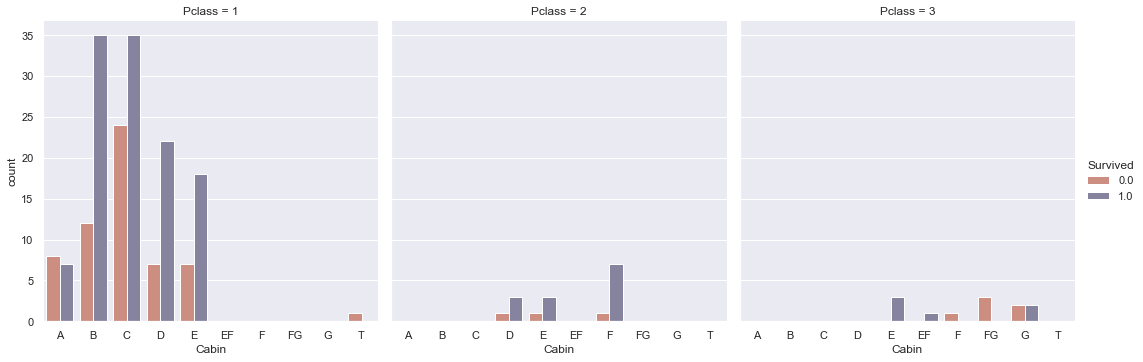

In [25]:
order = list(X.Cabin.dropna().unique())

sns.catplot(x="Cabin", kind="count", palette=survived_pallete, data=X, col = 'Pclass', hue = "Survived",
            order = sorted(order))

# Feature engineering

In [26]:
X_feature_selected = ['PassengerId','Survived', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Fare',
                      'Embarked', 'Ticket',  'Age_mod', 'Age_prob']
X = X[X_feature_selected]

It is interesting to see if there are some value from Name column. Name and Surname is not valuable in model building, but title is something that could be used.

In [27]:
X['Title']=X.Name.str.split(",",expand=True)[1].str.split(".",expand=True)[0]
X['Title'].value_counts()

<ipython-input-27-e253f2cf7529>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Title']=X.Name.str.split(",",expand=True)[1].str.split(".",expand=True)[0]


 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Dr                8
 Rev               8
 Col               4
 Major             2
 Mlle              2
 Ms                2
 Sir               1
 Jonkheer          1
 Lady              1
 Don               1
 the Countess      1
 Dona              1
 Capt              1
 Mme               1
Name: Title, dtype: int64

In [28]:
officer_title  = [' Capt',' Col',' Major']
community_title =[' Dr',' Sir']
rare_title =[' Dona', ' Lady', ' the Countess', ' Don', ' Rev', ' Jonkheer']

list_of_groups = [officer_title,community_title, rare_title]
name_of_groups = ['officer_title','community_title', 'rare_title']

X['Title_group']= X.Title
title_list = []

for _, l in enumerate(list_of_groups):
    for i in l:
        title_list.append(list((_, i)))
        
for i in title_list:
    X.loc[X['Title']==i[1], 'Title_group' ] = name_of_groups[i[0]]
    
X['Title_group'] = X.Title_group.replace(' Ms', ' Miss')
X['Title_group'] = X.Title_group.replace(' Mlle', ' Miss')
X['Title_group'] = X.Title_group.replace(' Mme', ' Mrs')
X.Title_group.value_counts()

<ipython-input-28-6753fb7ebb7c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Title_group']= X.Title
C:\Users\Data_Geeks\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-28-6753fb7ebb7c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

 Mr                757
 Miss              264
 Mrs               198
 Master             61
rare_title          13
community_title      9
officer_title        7
Name: Title_group, dtype: int64

<AxesSubplot:xlabel='Title_group', ylabel='frec'>

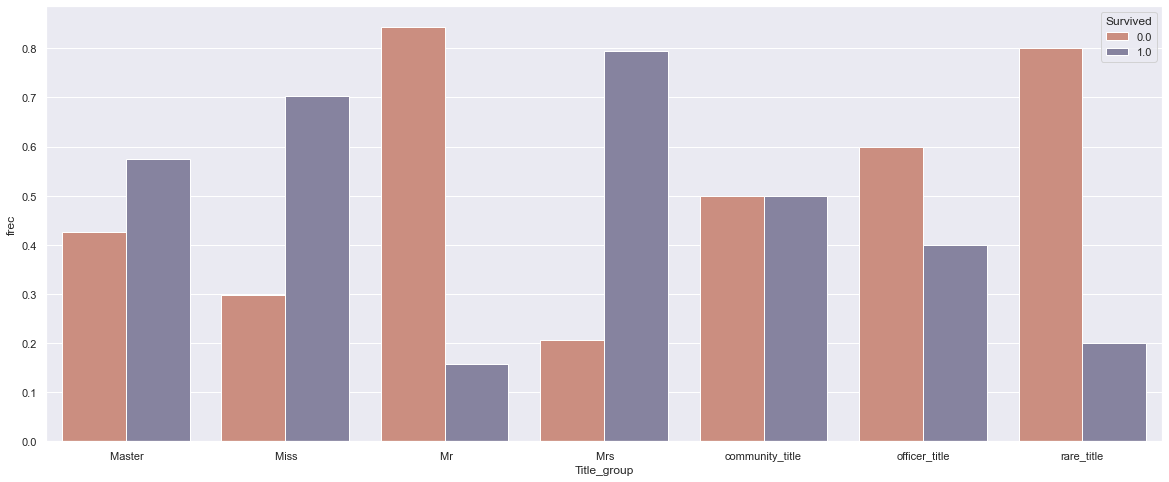

In [29]:
X_train = X[~(X['Survived'].isnull())]
frec_title =frec_table(X_train, 'Title_group', 'Survived', 'PassengerId')
fig, ax = plt.subplots(figsize=(20,8))

sns.barplot(x="Title_group", y = 'frec', hue="Survived",
                data=frec_title, ax=ax, palette = survived_pallete)

Is there any difference if you were alone or with the family in titanic?

<AxesSubplot:xlabel='Family', ylabel='frec'>

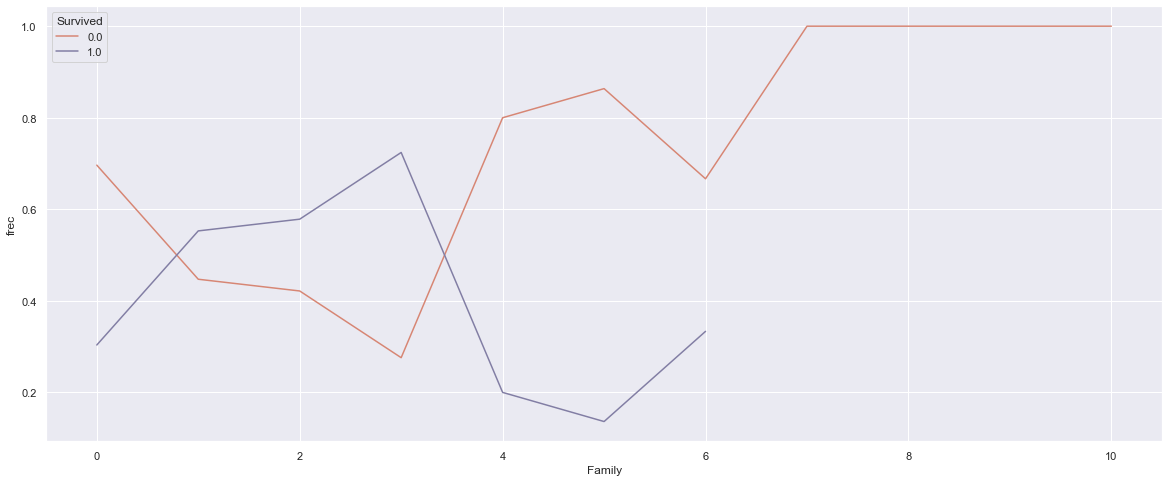

In [30]:
X['Family'] = X.SibSp + X.Parch

X_train = X[~(X['Survived'].isnull())]
frec_Family =frec_table(X_train, 'Family', 'Survived', 'PassengerId')

fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(x="Family", y = 'frec', hue="Survived",
                data=frec_Family, ax=ax, palette = survived_pallete)

In [31]:
Tickets = X[['Ticket','Fare', 'PassengerId']].groupby(['Ticket','Fare']).count().reset_index().rename(columns = {'PassengerId':'Together_ticket'})

X = pd.merge(X, Tickets, on="Ticket", how = "left")
X = X.drop(["Fare_y"], axis = 1)
X.head()

X['Together_ticket'] = X.Together_ticket.astype('int')
X['Friends'] = X.Together_ticket - X.Family
X.loc[X['Friends']<0, 'Friends']=0
X['Friends_and_Family']  =X.Family +X.Friends-1

X.loc[X['Friends_and_Family'] == 0, "Is Alone"] =1
X.loc[X['Friends_and_Family'] > 0, "Is Alone"] =0


In [32]:
display(X.head())

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex  SibSp  Parch  \
0                            Braund, Mr. Owen Harris    male      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female      1      0   
2                             Heikkinen, Miss. Laina  female      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female      1      0   
4                           Allen, Mr. William Henry    male      0      0   

    Fare_x Embarked            Ticket  Age_mod  Age_prob  Title Title_group  \
0   7.2500        S         A/5 21171     22.0      22.0     Mr          Mr   
1  71.2833        C          PC 17599     38.0      38.0    Mrs         Mrs   
2   7.9250        S  STON/O2. 3101282     26.0      26.0   Miss        Miss   
3  53.1000        S            113803     35.0      35.0    Mrs         Mrs   
4   8.0500        S            373450     35.0      35.0     Mr          Mr   

   Family  Together_ticket  Friends  Friends_and_Family  Is Alone  
0       1                1        0                   0       1.0  
1       1                2        1                   1       0.0  
2       0                1        1                   0       1.0  
3       1                2        1                   1       0.0  
4       0                1        1                   0       1.0

<AxesSubplot:xlabel='Is Alone', ylabel='frec'>

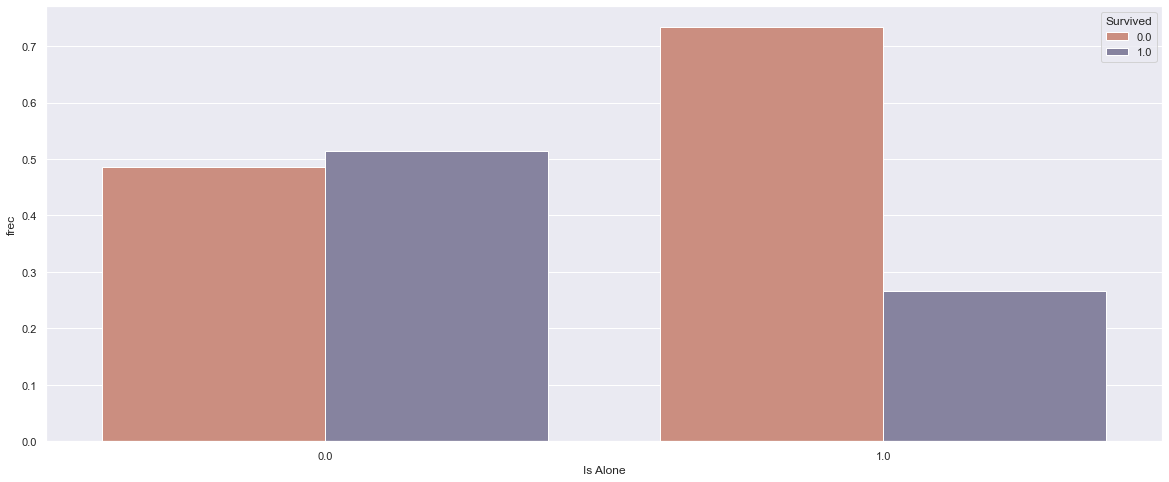

In [33]:
X_train = X[~(X['Survived'].isnull())]
frec_Alone =frec_table(X_train, 'Is Alone', 'Survived', 'PassengerId')

fig, ax = plt.subplots(figsize=(20,8))

sns.barplot(x="Is Alone", y = 'frec', hue="Survived",
                data=frec_Alone, ax=ax, palette = survived_pallete)

<AxesSubplot:xlabel='Friends', ylabel='frec'>

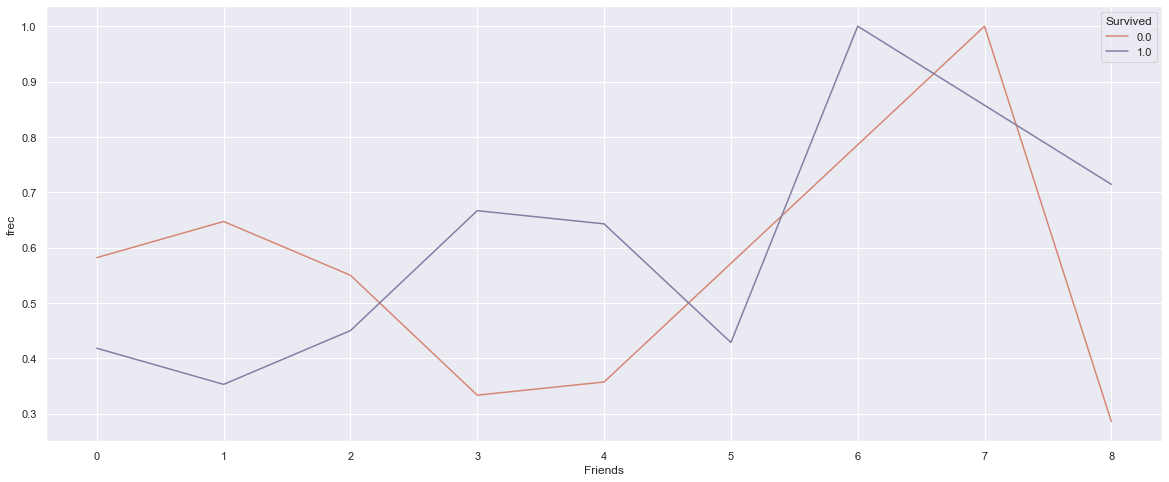

In [34]:
X_train = X[~(X['Survived'].isnull())]
frec_Friends =frec_table(X_train, 'Friends', 'Survived', 'PassengerId')

fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(x="Friends", y = 'frec', hue="Survived",
                data=frec_Friends, ax=ax, palette = survived_pallete)

<AxesSubplot:xlabel='Friends_and_Family', ylabel='frec'>

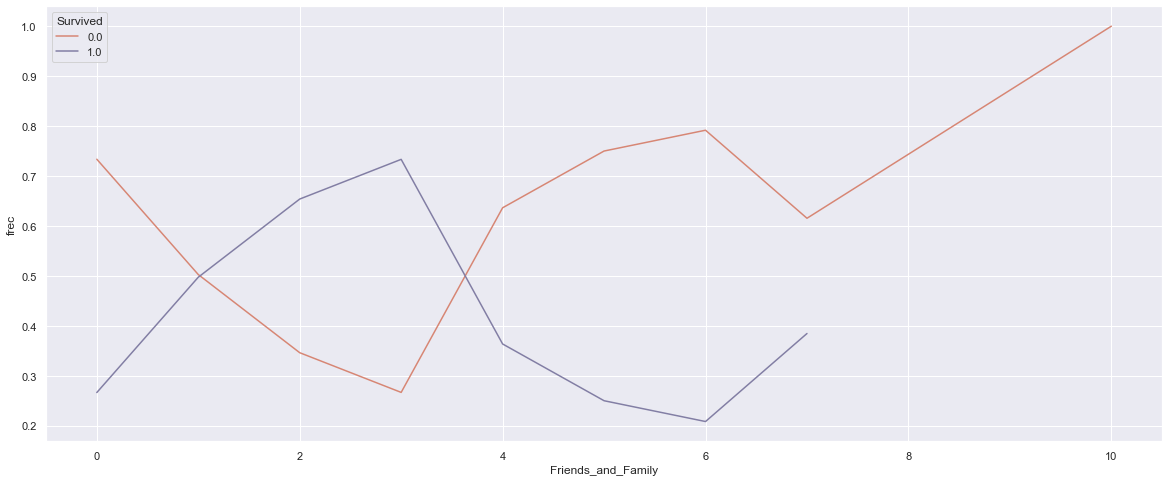

In [35]:
X_train = X[~(X['Survived'].isnull())]
frec_Friends_and_Family =frec_table(X_train, 'Friends_and_Family', 'Survived', 'PassengerId')

fig, ax = plt.subplots(figsize=(20,8))

sns.lineplot(x="Friends_and_Family", y = 'frec', hue="Survived",
                data=frec_Friends_and_Family, ax=ax, palette = survived_pallete)

In [36]:
kids_title=X_full[['Name', 'Age']][X_full[['Name', 'Age']].Age<=18]
kids_title['Title']=kids_title.Name.str.split(",",expand=True)[1].str.split(".",expand=True)[0]
kids_title['Title'].value_counts()

 Miss      81
 Master    53
 Mr        48
 Mrs       11
Name: Title, dtype: int64

In [37]:
X[['Survived', 'Age_mod', 'Age_prob']].dropna().corr()

Survived   Age_mod  Age_prob
Survived  1.000000 -0.043027 -0.062197
Age_mod  -0.043027  1.000000  0.918246
Age_prob -0.062197  0.918246  1.000000

In [38]:
kids_title=X[['Title', 'Age_prob']][X[['Title', 'Age_prob']].Age_prob<=18]

In [39]:
kids_title.Title.unique()

array([' Master', ' Mrs', ' Miss', ' Mr'], dtype=object)

In [40]:
X.loc[X.Age_prob<18, 'Kid'] = 1
X.loc[X.Age_prob>=18, 'Kid'] = 0

<AxesSubplot:xlabel='Kid', ylabel='frec'>

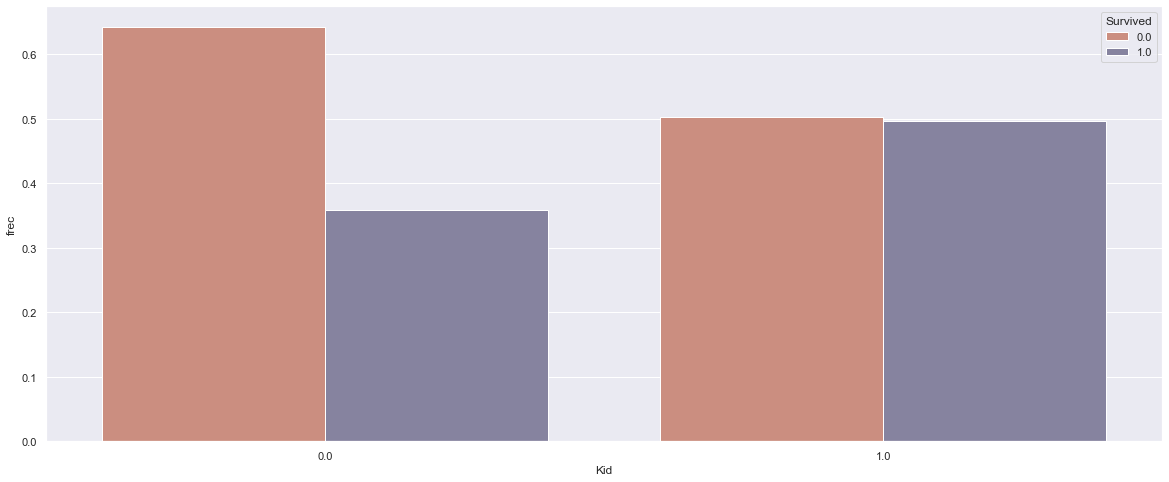

In [41]:
X_train = X[~(X['Survived'].isnull())]
frec_Kid =frec_table(X_train, 'Kid', 'Survived', 'PassengerId')

fig, ax = plt.subplots(figsize=(20,8))

sns.barplot(x="Kid", y = 'frec', hue="Survived",
                data=frec_Kid, ax=ax, palette = survived_pallete)

In [42]:
X.loc[(X.Sex=='female') & (X.Parch >=1) & (X.Age_prob >=18), 'Mother']=1
X['Mother'] = X['Mother'].fillna(0)
X.Mother.unique()

array([0., 1.])

<AxesSubplot:xlabel='Mother', ylabel='frec'>

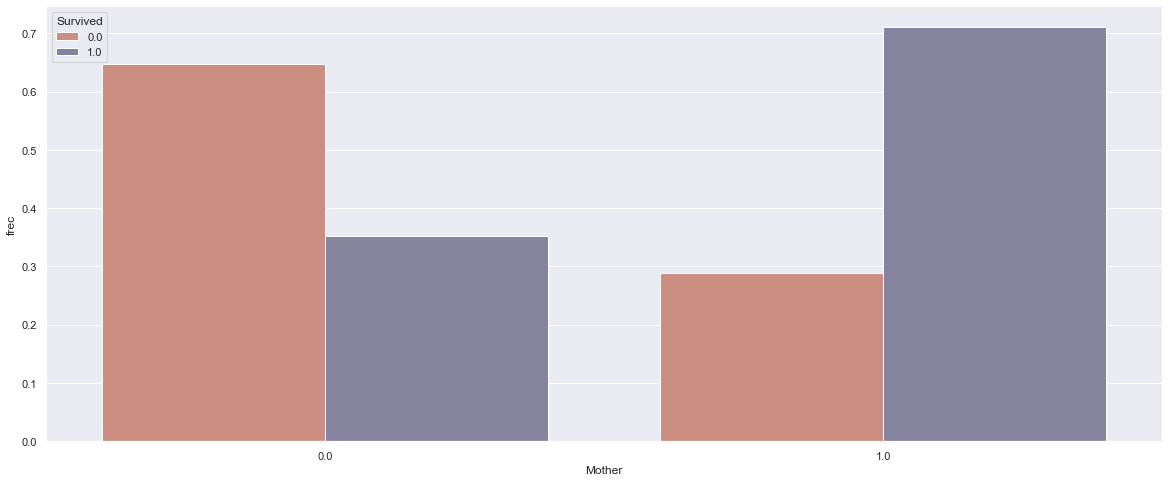

In [43]:
X_train = X[~(X['Survived'].isnull())]
frec_M =frec_table(X_train, 'Mother', 'Survived', 'PassengerId')

fig, ax = plt.subplots(figsize=(20,8))

sns.barplot(x="Mother", y = 'frec', hue="Survived",
                data=frec_M, ax=ax, palette = survived_pallete)

In [44]:
X.loc[(X.Kid == 1) | (X.Mother) == 1, "Mother or kid"] =1 
X["Mother or kid"] = X["Mother or kid"].fillna(0)

In [45]:
X_features = ['PassengerId','Pclass', 'Sex', 'SibSp', 'Parch','Fare_x', 'Embarked', 'Age_prob', 
       'Title_group', 'Family', 'Together_ticket', 'Friends',
       'Friends_and_Family', 'Is Alone', 'Kid', 'Mother', 'Mother or kid','Survived']
X = X[X_features]
X.head()

PassengerId  Pclass     Sex  SibSp  Parch   Fare_x Embarked  Age_prob  \
0            1       3    male      1      0   7.2500        S      22.0   
1            2       1  female      1      0  71.2833        C      38.0   
2            3       3  female      0      0   7.9250        S      26.0   
3            4       1  female      1      0  53.1000        S      35.0   
4            5       3    male      0      0   8.0500        S      35.0   

  Title_group  Family  Together_ticket  Friends  Friends_and_Family  Is Alone  \
0          Mr       1                1        0                   0       1.0   
1         Mrs       1                2        1                   1       0.0   
2        Miss       0                1        1                   0       1.0   
3         Mrs       1                2        1                   1       0.0   
4          Mr       0                1        1                   0       1.0   

   Kid  Mother  Mother or kid  Survived  
0  0.0     0.0            0.0       0.0  
1  0.0     0.0            0.0       1.0  
2  0.0     0.0            0.0       1.0  
3  0.0     0.0            0.0       1.0  
4  0.0     0.0            0.0       0.0

In [46]:
Sex_male = pd.get_dummies(X['Sex'])
X['Sex'] = Sex_male['male'] 
X.head(3)

PassengerId  Pclass  Sex  SibSp  Parch   Fare_x Embarked  Age_prob  \
0            1       3    1      1      0   7.2500        S      22.0   
1            2       1    0      1      0  71.2833        C      38.0   
2            3       3    0      0      0   7.9250        S      26.0   

  Title_group  Family  Together_ticket  Friends  Friends_and_Family  Is Alone  \
0          Mr       1                1        0                   0       1.0   
1         Mrs       1                2        1                   1       0.0   
2        Miss       0                1        1                   0       1.0   

   Kid  Mother  Mother or kid  Survived  
0  0.0     0.0            0.0       0.0  
1  0.0     0.0            0.0       1.0  
2  0.0     0.0            0.0       1.0

In [47]:
X['Title_group'] = X.Title_group.astype('category')
X.loc[:,'Title_num'] = X.Title_group.cat.codes

X = X.drop('Title_group', axis = 1)
X.head(3)

PassengerId  Pclass  Sex  SibSp  Parch   Fare_x Embarked  Age_prob  Family  \
0            1       3    1      1      0   7.2500        S      22.0       1   
1            2       1    0      1      0  71.2833        C      38.0       1   
2            3       3    0      0      0   7.9250        S      26.0       0   

   Together_ticket  Friends  Friends_and_Family  Is Alone  Kid  Mother  \
0                1        0                   0       1.0  0.0     0.0   
1                2        1                   1       0.0  0.0     0.0   
2                1        1                   0       1.0  0.0     0.0   

   Mother or kid  Survived  Title_num  
0            0.0       0.0          2  
1            0.0       1.0          3  
2            0.0       1.0          1

In [48]:
X = pd.get_dummies(X, drop_first = True)
X.head()

PassengerId  Pclass  Sex  SibSp  Parch   Fare_x  Age_prob  Family  \
0            1       3    1      1      0   7.2500      22.0       1   
1            2       1    0      1      0  71.2833      38.0       1   
2            3       3    0      0      0   7.9250      26.0       0   
3            4       1    0      1      0  53.1000      35.0       1   
4            5       3    1      0      0   8.0500      35.0       0   

   Together_ticket  Friends  Friends_and_Family  Is Alone  Kid  Mother  \
0                1        0                   0       1.0  0.0     0.0   
1                2        1                   1       0.0  0.0     0.0   
2                1        1                   0       1.0  0.0     0.0   
3                2        1                   1       0.0  0.0     0.0   
4                1        1                   0       1.0  0.0     0.0   

   Mother or kid  Survived  Title_num  Embarked_Q  Embarked_S  
0            0.0       0.0          2           0           1  
1            0.0       1.0          3           0           0  
2            0.0       1.0          1           0           1  
3            0.0       1.0          3           0           1  
4            0.0       0.0          2           0           1

In [49]:
X_features = ['PassengerId','Pclass', 'Sex', 'SibSp', 'Parch', 'Fare_x', 'Age_prob', 'Family',
       'Together_ticket', 'Friends', 'Friends_and_Family', 'Is Alone', 'Kid',
       'Mother', 'Mother or kid', 'Title_num', 'Embarked_Q',
       'Embarked_S','Survived']
X = X[X_features]
X.head()

PassengerId  Pclass  Sex  SibSp  Parch   Fare_x  Age_prob  Family  \
0            1       3    1      1      0   7.2500      22.0       1   
1            2       1    0      1      0  71.2833      38.0       1   
2            3       3    0      0      0   7.9250      26.0       0   
3            4       1    0      1      0  53.1000      35.0       1   
4            5       3    1      0      0   8.0500      35.0       0   

   Together_ticket  Friends  Friends_and_Family  Is Alone  Kid  Mother  \
0                1        0                   0       1.0  0.0     0.0   
1                2        1                   1       0.0  0.0     0.0   
2                1        1                   0       1.0  0.0     0.0   
3                2        1                   1       0.0  0.0     0.0   
4                1        1                   0       1.0  0.0     0.0   

   Mother or kid  Title_num  Embarked_Q  Embarked_S  Survived  
0            0.0          2           0           1       0.0  
1            0.0          3           0           0       1.0  
2            0.0          1           0           1       1.0  
3            0.0          3           0           1       1.0  
4            0.0          2           0           1       0.0

<AxesSubplot:>

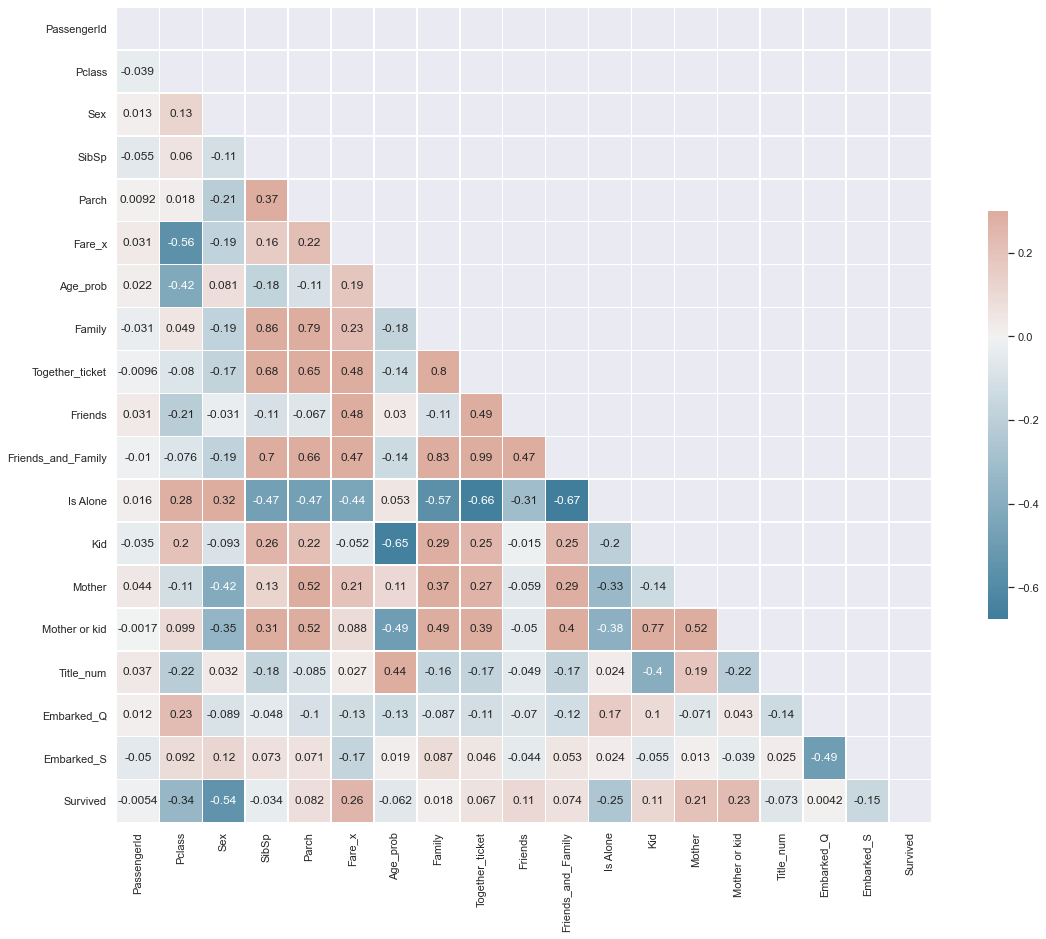

In [50]:

corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

# Splitting Data

In [51]:
X_features = ['PassengerId','Pclass', 'Sex', 'SibSp', 'Parch', 'Fare_x', 'Age_prob', 'Family',
       'Together_ticket', 'Friends', 'Friends_and_Family', 'Is Alone', 'Kid',
       'Mother', 'Mother or kid', 'Title_num', 'Embarked_Q',
       'Embarked_S']
y_features = 'Survived'
y = X[y_features]
X = X[X_features]

print('Train data set ' , len(train_data), ' To predict data set ', len(test_data))

predict = X['PassengerId']>=len(train_data)+1

X_predict = X[predict]
print('X_predict  ', X_predict.shape)

train = X['PassengerId']<len(train_data)-1
X = X[train]

y = y[:891]
print('y data ' , len(y))
print('X data ' , len(X))
X = X.drop("PassengerId", axis = 1)
X_predict = X_predict.drop("PassengerId", axis = 1)
X.head()
Head = X.columns

X_predict.head()

Train data set  891  To predict data set  418
X_predict   (418, 18)
y data  891
X data  891


Pclass  Sex  SibSp  Parch   Fare_x  Age_prob  Family  Together_ticket  \
893       3    1      0      0   7.8292      35.0       0                1   
894       3    0      1      0   7.0000      47.0       1                1   
895       2    1      0      0   9.6875      62.0       0                1   
896       3    1      0      0   8.6625      27.0       0                1   
897       3    0      1      1  12.2875      22.0       2                2   

     Friends  Friends_and_Family  Is Alone  Kid  Mother  Mother or kid  \
893        1                   0       1.0  0.0     0.0            0.0   
894        0                   0       1.0  0.0     0.0            0.0   
895        1                   0       1.0  0.0     0.0            0.0   
896        1                   0       1.0  0.0     0.0            0.0   
897        0                   1       0.0  0.0     1.0            1.0   

     Title_num  Embarked_Q  Embarked_S  
893          2           1           0  
894          3           0           1  
895          2           1           0  
896          2           0           1  
897          3           0           1

# Imortance analysis

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify = y)

In [54]:
X_train_not_scaled = X_train
X_test_not_scaled = X_test


ss = StandardScaler()
Head = X_train.columns
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)


In [55]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [56]:
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns=[f'PC{i}' for i in range(1, len(Head) + 1)],
    index=Head
)
loadings.head(3)

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Pclass -0.081917 -0.680247 -0.134017  0.257343  0.258499  0.499161  0.017423   
Sex    -0.390222 -0.010688  0.201397  0.526873  0.155034 -0.119706  0.533824   
SibSp   0.736199 -0.128051 -0.042752  0.336295  0.352795 -0.272670 -0.061939   

             PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
Pclass  0.006692  0.191073  0.063170  0.089549  0.061317  0.281361 -0.000168   
Sex    -0.406161  0.001633 -0.041506 -0.132155 -0.152212  0.014295  0.000212   
SibSp   0.264375 -0.040147  0.088805  0.040645 -0.208353  0.024192  0.020200   

                PC15          PC16          PC17  
Pclass  5.534603e-31  8.678927e-32  4.589684e-33  
Sex     4.723044e-31  5.056440e-32 -1.942542e-31  
SibSp  -4.389595e-16  2.250508e-16  2.340383e-16

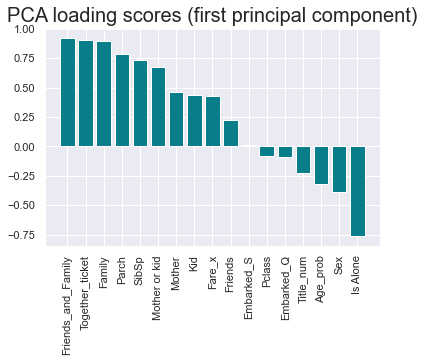

In [57]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [58]:
pc1_loadings['CorrelationWithPC1_abs'] = abs(pc1_loadings['CorrelationWithPC1'])
PCA_table = pc1_loadings.sort_values(by=['CorrelationWithPC1_abs'], ascending  = False)
PCA_table = PCA_table[PCA_table.CorrelationWithPC1_abs>=0.3]
display(np.array(PCA_table.Attribute))

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]


column_index(X, np.array(PCA_table.Attribute))
pca_important = column_index(X, np.array(PCA_table.Attribute))

array(['Friends_and_Family', 'Together_ticket', 'Family', 'Parch',
       'Is Alone', 'SibSp', 'Mother or kid', 'Mother', 'Kid', 'Fare_x',
       'Sex', 'Age_prob'], dtype=object)

In [59]:
X_train1 = X_train[:,pca_important]
X_test1 = X_test[:,pca_important]
X_train1.shape

(712, 12)

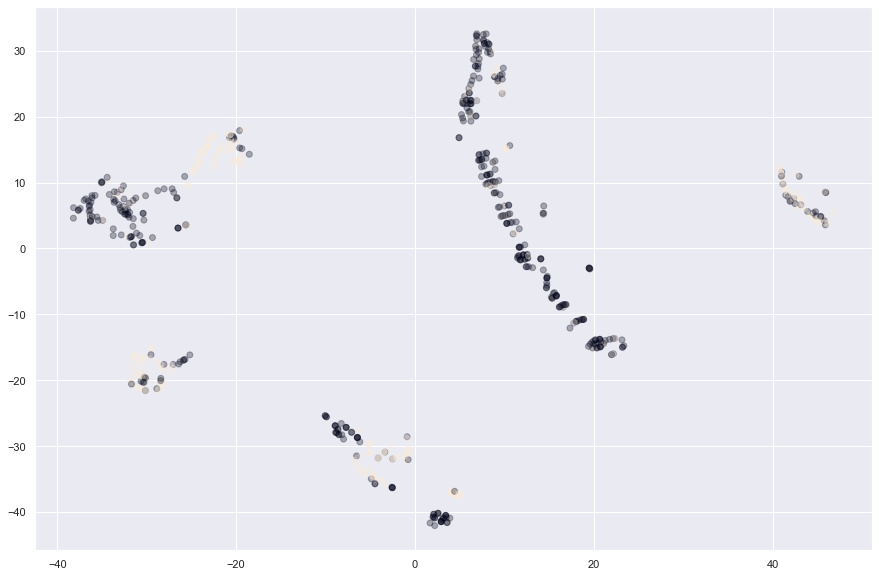

In [60]:

from sklearn.manifold import TSNE

model = TSNE(learning_rate=200)

tsne_features = model.fit_transform(X_train1)

xs = tsne_features[:,0]
ys = tsne_features[:,1]
f, ax = plt.subplots(figsize=(15, 10))
plt.scatter(xs, ys, c=y_train, alpha = 0.3)
plt.show()

In [61]:
steps = [('knn', KNeighborsClassifier())]
          
parameters = {'knn__n_neighbors': np.arange(1, 10)}

pipeline = Pipeline(steps)

cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

cv.fit(X_train1, y_train)

y_pred = cv.predict(X_test1)

print(cv.best_params_)
print(cv.best_score_)

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy_knn = accuracy_score(np.array(y_test), y_pred)


{'knn__n_neighbors': 9}
0.7991923569388358
[[99 11]
 [20 49]]
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       110
         1.0       0.82      0.71      0.76        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



In [62]:
steps = [('logreg', LogisticRegression(solver = 'saga', max_iter=1200))]
          
c_space = np.logspace(-5, 8, 15)
param_grid = {'logreg__C': c_space, 'logreg__penalty': ['l1', 'l2']}

pipeline = Pipeline(steps)

logreg_cv = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

logreg_cv.fit(X_train1, y_train)

y_pred = logreg_cv.predict(X_test1)

print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy_log = accuracy_score(np.array(y_test), y_pred)

Tuned Logistic Regression Parameter: {'logreg__C': 268.2695795279727, 'logreg__penalty': 'l1'}
Tuned Logistic Regression Accuracy: 0.8005811090318133
[[100  10]
 [ 24  45]]
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.85       110
         1.0       0.82      0.65      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



In [63]:

dt = DecisionTreeClassifier(max_depth= 9, max_features= 0.8, min_samples_leaf= 0.1, criterion='gini', random_state=1)

MSE_CV_scores = -cross_val_score(dt, X_train1, y_train,
                        scoring='neg_mean_squared_error', 
                       cv=10,
                       n_jobs=-1)
RMSE_CV = (MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE: {:.2f}'.format(RMSE_CV))
dt.fit(X_train1,y_train) #X_train_not_scaled

y_pred = dt.predict(X_test1) #X_test_not_scaled

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy_DTC = accuracy_score(np.array(y_test), y_pred)

CV RMSE: 0.46
[[97 13]
 [23 46]]
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       110
         1.0       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



In [64]:
rf = RandomForestClassifier(n_estimators=250,
            random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train1, y_train) 


# Predict the test set labels
y_pred = rf.predict(X_test1)

# Evaluate the test set RMSE
rmse_test = MSE(y_test,y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

# Calculate accuracy score
accuracy = accuracy_score(np.array(y_test), y_pred)
print('Random Forest Classifier accuracy: {:.3f}'.format(accuracy))
accuracy_RF = accuracy_score(np.array(y_test), y_pred)

Test set RMSE of rf: 0.42


Random Forest Classifier accuracy: 0.821


In [65]:
print("knn ",accuracy_knn)
print("log ", accuracy_log)
print("DTC", accuracy_DTC)
print("RF ", accuracy_RF)


knn  0.8268156424581006
log  0.8100558659217877
DTC 0.7988826815642458
RF  0.8212290502793296


In [66]:
from sklearn.ensemble import RandomForestClassifier
# Set seed for reproducibility
SEED=1
knn = KNeighborsClassifier(n_neighbors=9)
lr = LogisticRegression(solver = 'saga', max_iter=400)
dt = DecisionTreeClassifier(max_depth= 9, max_features= 0.8, min_samples_leaf= 0.1, criterion='gini', random_state=1)
rf = RandomForestClassifier(n_estimators=250,
            random_state=2)

classifiers = [('K Nearest Neighbours', knn),('Logistic Regression', lr), 
                ('Random Forest Classifier', rf)]

for clf_name, clf in classifiers:      
   
    clf.fit(X_train1, y_train)    
    y_pred = clf.predict(X_test1)

    accuracy = accuracy_score(y_test, y_pred)
    print('{:s} : {:.3f}'.format(clf_name, accuracy))
    
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=classifiers)     
vc.fit(X_train1, y_train)   
y_pred = vc.predict(X_test1)

accuracy = accuracy_score(y_test, y_pred)
print('Voting Classifier: {:.3f}'.format(accuracy))

K Nearest Neighbours : 0.827
Logistic Regression : 0.810
Random Forest Classifier : 0.821
Voting Classifier: 0.849


In [67]:
X_predict = ss.transform(X_predict)
X_predict1 = X_predict[:,pca_important]

y_pred_vot = vc.predict(X_predict1)

output_vc = pd.DataFrame(data={
    'PassengerId': test_data['PassengerId'],
    'Survived': y_pred_vot.astype('int')
})

print(output_vc.head())

Target_file = r"C:\Users\Data_Geeks\Desktop\Data Science projects\Titanic\output_vc20210225.csv"
output_vc.to_csv(Target_file,index=False)

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         0
